# Preprocesamiento del Dataset y Selección de Variables

Este notebook tienen como objetivo la fase de "ingeniería" donde transformamos los **datos crudos** (los que obtuvimos en el EDA) en el combustible limpio y de alto octanaje que usaremos para entrenar nuestros modelos.

Basado en nuestros hallazgos en la fase anterior (outliers, gaps, MNAR, correlaciones), tomarmos decicisones que nos lleven a alcanzar ese objetivo.

# Fase A: Preparación de Datos Base

## 1. Carga de Datos

In [106]:
# Seteo inicial

import sys
import logging
import warnings
from pathlib import Path

# Configuración de logging y advertencias
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')
warnings.filterwarnings('ignore')


# Configuración de Paths
BASE_DIR = Path('../').resolve()
DATA_DIR = BASE_DIR / 'data'
SRC_DIR = BASE_DIR / 'src'
RAW_DIR = DATA_DIR / 'raw'
PROCESSED_DIR = DATA_DIR / 'processed'
sys.path.append(str(SRC_DIR))

logging.info(f"Directorio Base: {BASE_DIR}")
logging.info(f"Directorio de Datos: {DATA_DIR}")
logging.info(f"Directorio Procesado: {PROCESSED_DIR}")
logging.info(f"Directorio Src: {SRC_DIR}")

2025-11-14 20:54:22,890 - Directorio Base: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF
2025-11-14 20:54:22,891 - Directorio de Datos: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/data
2025-11-14 20:54:22,892 - Directorio Procesado: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/data/processed
2025-11-14 20:54:22,893 - Directorio Src: /Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/src


### Cargar el Dataset Base

In [107]:
import pandas as pd

df = pd.read_csv(PROCESSED_DIR / 'dataset_v01.csv', parse_dates=['Fecha'], index_col='Fecha')

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1190 entries, 2020-07-01 23:59:00 to 2023-10-26 07:00:00
Columns: 149 entries, Planta (Kw) to Totalizador_Filtracion
dtypes: float64(145), int64(4)
memory usage: 1.4 MB


---

## 2. Limpieza y Acondicionamiento de fechas.

### Limpieza de Rango de Fechas

Como vimos durante el EDA, algunas de nuestras fechas faltan o estan incompletas (no llegan hasta las 23:59). En este apartado vamos a tratar esas filas para dejarlas en condiciones antes del preporcesado.

In [108]:
# Ejemplo de fila incompleta
df.last_valid_index()

Timestamp('2023-10-26 07:00:00')

En este caso, como `2023-10-26` es la última fila lo más sencillo es eliminarla. Esto ya que no provoca una pérdida de continuidad y tenemos datos suficientes como para permitirnoslo.

In [109]:
df = df.loc[df.index < '2023-10-26']

# Nuestra fecha máxima de datos ahora es 2023-10-25
df.last_valid_index()

Timestamp('2023-10-25 23:59:00')

Ahora vamos a buscar las fechas con horas distintas a las `23:59:00` y decidiremos si las eliminamos (considerándolas como día faltantes) o si las conservamos como están.

In [110]:
import numpy as np

# Verificar si hay fechas con horas distintas a 23:59:00

# Extraer la hora de cada índice
df_horas = df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S'))

# Identificar las fechas que no terminan en 23:59:00
fechas_incompletas = df[df_horas != '23:59:00']

print(f"Total de fechas con horas distintas a 23:59:00: {len(fechas_incompletas)}")

print("\nFechas incompletas encontradas:")
# Las ordenamos por hora de forma ascendente para facilitar su revisión y solo comparamos la columna 'Frio (Kw)'
fechas_incompletas = fechas_incompletas.assign(hora=df_horas[df_horas != '23:59:00']).sort_values(by='hora')
display(fechas_incompletas['Frio (Kw)'])

Total de fechas con horas distintas a 23:59:00: 19

Fechas incompletas encontradas:


Fecha
2023-04-19 16:00:00    13439.0
2023-04-13 19:00:00    14315.0
2022-03-02 23:00:00    19294.0
2021-07-13 23:00:00    33704.0
2023-02-23 23:59:01    20688.0
2022-12-08 23:59:01    21663.0
2022-04-29 23:59:01    31316.0
2022-04-05 23:59:01    22573.0
2020-08-12 23:59:01    29964.0
2021-04-11 23:59:01    26888.0
2020-12-30 23:59:01    11433.0
2020-10-22 23:59:01    28374.0
2020-10-08 23:59:01    30220.0
2020-08-25 23:59:01    37809.0
2021-08-25 23:59:01    37122.0
2023-07-07 23:59:01    22348.0
2023-06-30 23:59:59    20274.0
2021-06-30 23:59:59    32571.0
2022-06-30 23:59:59    26459.0
Name: Frio (Kw), dtype: float64

Como vemos, la gran mayoría de estas fechas tienen diferencias de **segundos** con la hora que estamos comparando, por lo que vamos a tomarlas como válidas. También lo haremos con las fechas con hora `23:00:00`, siguen aportando información relevante y suficiente para nuestro análisis.

En cambio, aquellos días que poseen horas `< 23:00:00` vamos a eliminarlas y las tomaremos como valores faltantes que trataremos más adelante.

In [111]:
print("Shape previo a filtrado:", df.shape)

df =  df.loc[~((df.index.to_series().apply(lambda x: x.strftime('%H:%M:%S')) < '23:00:00'))]

print("Shape posterior a filtrado:", df.shape)

Shape previo a filtrado: (1189, 149)
Shape posterior a filtrado: (1187, 149)


In [112]:
# Eliminar la hora del índice, dejando solo la fecha
df.index = df.index.normalize()
df.tail()

,Planta (Kw),Elaboracion (Kw),Bodega (Kw),Cocina (Kw),Envasado (Kw),Linea 2 (Kw),Linea 3 (Kw),Linea 4 (Kw),Servicios (Kw),Sala Maq (Kw),...,Tot L3. L4 y Planta de CO2,Tot A40/240/50/60/Centec/Filtro,Tot A130/330/430,"Tot L3, L4 y Planta de CO2",Totalizador_L2_Barriles,Totalizador_L3,Totaliador_Latas,Totalizador_Bodega,Totalizador_Tq_Pulmon,Totalizador_Filtracion
Fecha,,,,,,,,,,,,,,,,,,,,,
2023-10-21,21627.800000,2383.0,3119.0,242.0,452.0,461.300000,546.0,0.0,16977.0,9793.0,...,NaN,2194.000,6922.250,40.12500,0.0,0.0,0.0,0.0000,1649.0,0.0
2023-10-22,30287.570000,3200.0,2788.0,1387.0,2758.0,4351.070000,584.0,0.0,20821.0,11873.0,...,NaN,2070.875,6019.625,72.56250,1271.0,0.0,0.0,7.9375,2863.0,1.0
2023-10-23,28667.480000,2329.0,2882.0,313.0,3339.0,5503.480000,550.0,0.0,18771.0,10395.0,...,NaN,1828.250,6030.000,74.53125,1323.0,0.0,0.0,0.0000,3244.0,1.0
2023-10-24,31263.160156,3077.0,3405.0,235.0,5513.0,6940.660156,1287.0,0.0,18461.0,10614.0,...,NaN,728.500,6006.000,79.78125,1485.0,0.0,0.0,952.0625,4538.0,737.0
2023-10-25,30501.320312,3194.0,3671.0,251.0,4306.0,6812.820312,528.0,0.0,18692.0,10809.0,...,NaN,1191.625,5969.625,54.93750,1217.0,0.0,0.0,1690.5625,4756.0,1552.0


### Tratado de Gaps y re-index de fechas

En el EDA encontramos que nuestro dataset presentaba inconsistencias en cuanto a la continuidad temporal, nos faltaban algunos días de manera aleatoria y otros no tanto. Vamos a analizar los contextos y solucionar respecto a ellos:

**Análisis de las Opciones**

- **Días 31 Faltantes:**

    - *Opción 1:* Asumir meses de 30 días. 
    En esta opción estaríamos eliminando días reales de consumo (como 31/Ene, 31/Mar, 31/Jul) solo porque algunos 31s fallaron. Esto sesgaría la estacionalidad y perderíamos información valiosa.

    - *Opción 2:* Imputar. 
    Estos parecen ser errores de registro (aleatorios o sistemáticos). La planta operó y consumió energía, pero el dato no se guardó. Deben ser tratados como NaN y ser imputados más tarde.

- **Agosto 29, 30, 31 (Patrón Anual):**
    
    La mejor estrategia sería asumir que estos días la planta tiene consumo cero. Esto probablemente se deba a un *cierre de mantenimiento programado anual* al final del verano.
    
    Imputaremos 0 en esos días para enseñarle a los modelos dos cosas vitales:

    1. Que el consumo en esos días específicos es cero (o cercano a cero).
    
    2. Cómo es el arranque de la planta el 1 de septiembre (el lag_1_Frio será 0, algo que el modelo debe aprender).

In [113]:
# --- Reindexar para exponer los Gaps ---

# Usamos tu rango de fechas corregido

print(f"Forma original: {df.shape}")
# Definir el rango de fechas completo y correcto
full_date_range = pd.date_range(start='2020-07-01', end='2023-10-25', freq='D')

# Re-indexar para crear los 42 días faltantes como filas NaN
# df_full = df.reindex(full_date_range)
# print(f"Forma re-indexada: {df_full.shape}")

#Por ahora no agregamos filas NaN
df_full = df.copy()

Forma original: (1187, 149)


In [114]:
# Partimos de df_full = df.copy()
# Este codigo lo agregamos para poder indexar manualmente los dias 29-30-31 de agosto de los años 2020-2023

# Definimos los años y los días de shutdown
years = [2020, 2021, 2022, 2023]
days = [29, 30, 31]
month = 8  # agosto

# Creamos las fechas de shutdown
shutdown_dates = pd.to_datetime(
    [f"{y}-08-{d:02d}" for y in years for d in days]
)

# Si tu índice tiene horas (datetime completo), normalizamos ambos a fecha
df_full.index = pd.to_datetime(df_full.index).normalize()
shutdown_dates = shutdown_dates.normalize()

# Creamos un nuevo índice que es la unión del actual + los shutdowns
new_index = df_full.index.union(shutdown_dates)

# Reindexamos SOLO a ese índice extendido
df_full = df_full.reindex(new_index)


In [115]:
# --- Imputar manualmente todo con 0 ---

# Usamos .loc[] para asignar el valor en las filas correctas
shutdown_mask = ((df_full.index.month == 8) & 
                 ((df_full.index.day == 29) | (df_full.index.day == 30) | (df_full.index.day == 31))
                )
df_full.loc[shutdown_mask, :] = 0

# Validación
print("Validación de imputación manual (debería ser 0.0):")
print(df_full.loc['2020-08-29']['Frio (Kw)'])
print(df_full.loc['2021-08-30']['Frio (Kw)'])
print(df_full.loc['2022-08-31']['Frio (Kw)'])

Validación de imputación manual (debería ser 0.0):
0.0
0.0
0.0


### Eliminación de columnas sin información

In [116]:
df_full.isna().sum().sort_values(ascending=False).loc[lambda x: x > 0]

Agua Cocina (Hl)                   1186
Agua Elaboracion (Hl)              1186
Agua CO2                           1186
Agua Dilucion (Hl)                 1186
Agua Envasado (Hl)                 1186
Agua Servicios (Hl)                1186
Planta de agua (Hl)                1186
Produccion (Hl)                    1186
Red L1 y L2                        1186
FC L1 y L2                         1186
FC Lavadora L2                     1186
Red L3                             1186
FC Lavadora L3                     1186
Red Paste L4                       1186
FC Barriles                        1186
Agua Paste L3                      1186
Agua Lavadora L3                   1186
Agua Cond Evaporativos             1186
Agua Calderas                      1186
Agua Bodega (Hl)                   1186
Agua Efluentes                     1186
Agua Planta (Hl)                   1186
Tot L3, L4 y Planta de CO2          716
Tot L3. L4 y Planta de CO2          584
Tot Fermantacion_Cocina             574


Columnas eliminadas por tener más del 30% de valores NaN: 29
Forma del dataset después de eliminar columnas sin información: (1198, 120)


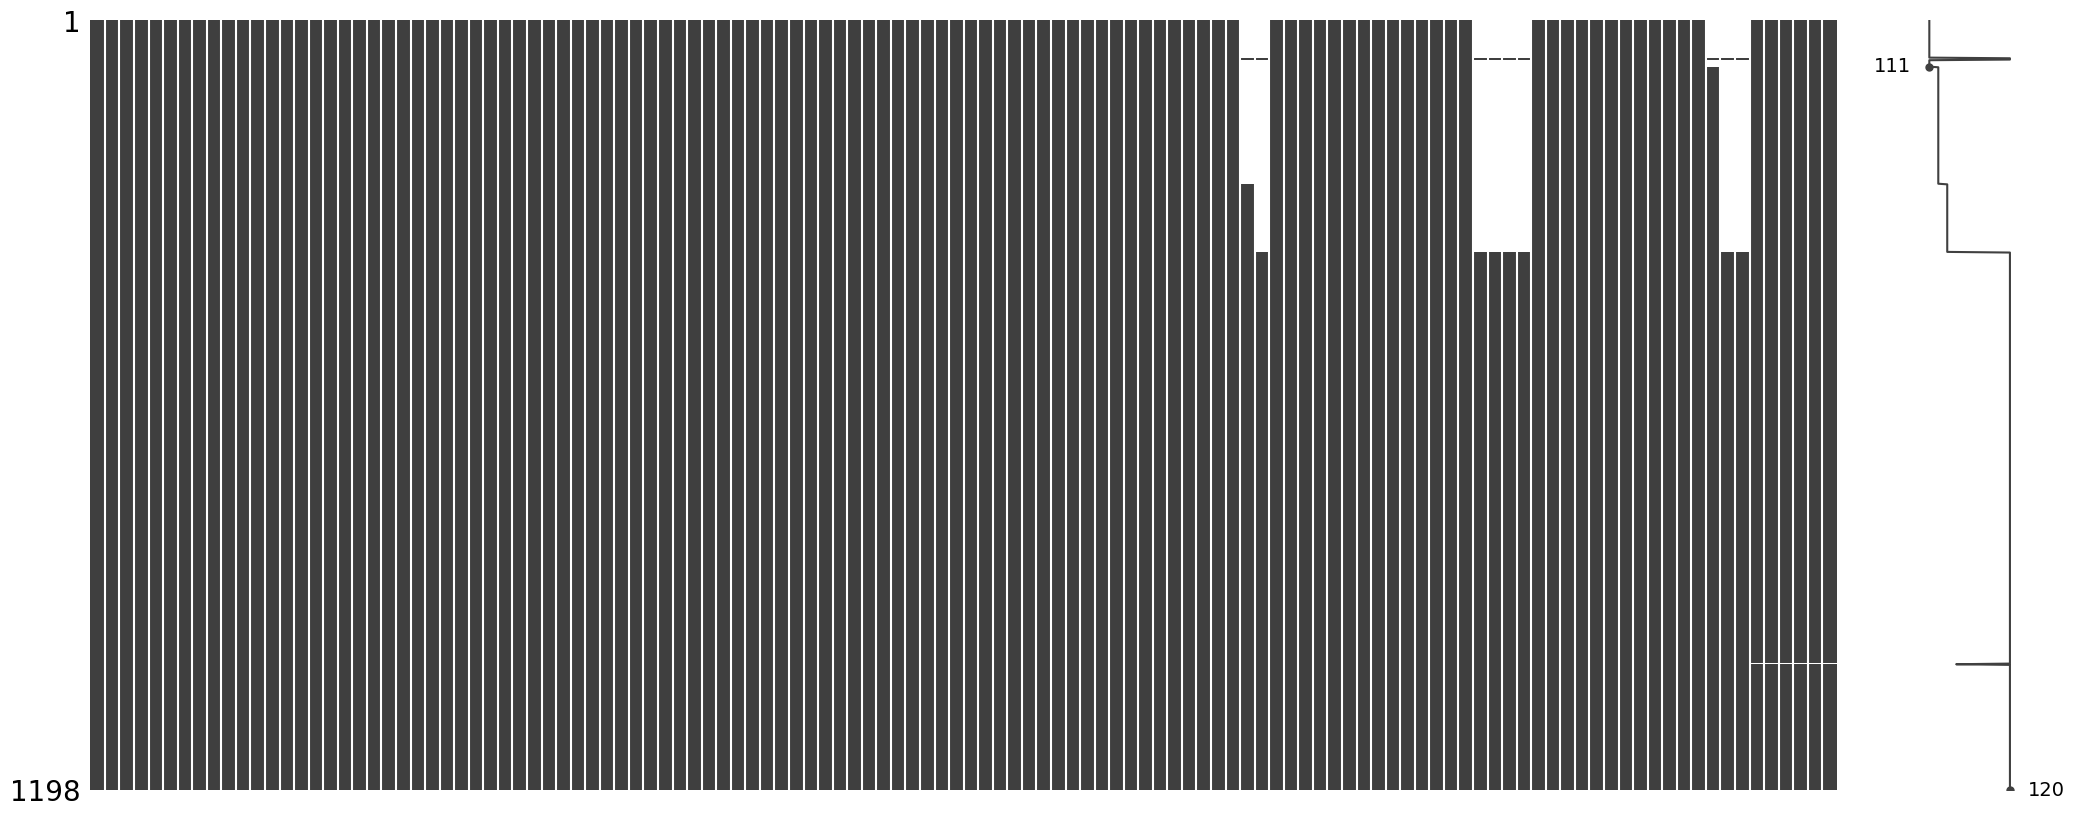

In [117]:
# --- Eliminar columnas sin información ---

# Eliminar columnas con más del 30% de valores NaN
df_full = df_full.loc[:, df_full.isna().mean() < 0.3]

# Tamaño del dataset después de eliminar columnas sin información
print("Columnas eliminadas por tener más del 30% de valores NaN:", df.shape[1] - df_full.shape[1])
print(f"Forma del dataset después de eliminar columnas sin información: {df_full.shape}")
import missingno as msno
import matplotlib.pyplot as plt

msno.matrix(df_full)
plt.show()

In [118]:
from aux_functions import track_data_artifact

df_full.to_csv(PROCESSED_DIR / 'dataset_v2.csv')

track_data_artifact(
	PROCESSED_DIR / 'dataset_v2.csv',
	'Dataset con fechas normalizadas y gaps expuestos',
	[PROCESSED_DIR / 'dataset_v2.csv'],
	parameters={'description': 'Dataset con fechas normalizadas, gaps expuestos y mantenimientos de agosto imputados a 0'},
	base_dir=BASE_DIR,
	checksums_file_path=DATA_DIR / 'checksums.json',
	lineage_file_path=PROCESSED_DIR / 'data_lineage.json',
)

2025-11-14 20:54:23,216 - --- Iniciando tracking de artefacto para: dataset_v2.csv ---
2025-11-14 20:54:23,217 - Checksum (SHA256): e582342042b48be1d1dd485bb0c9ee69142ecc7098d1be2140e5ee77baf5f97e
2025-11-14 20:54:23,218 - Checksum guardado en checksums.json
2025-11-14 20:54:23,220 - Data lineage actualizado en data_lineage.json
2025-11-14 20:54:23,220 - --- Tracking de artefacto completado ---


---

## 3. Split de Datos

In [119]:
# Dividir en train, val y test para busqueda de hiperparámetros del pipeline de preprocesamiento

# Train 70%
train_size = int(len(df_full) * 0.7)
train_df = df_full.iloc[:train_size]

# Validation 10%
val_size = int(len(df_full) * 0.1)
val_df = df_full.iloc[train_size:train_size + val_size]

# Test 20%
test_df = df_full.iloc[train_size + val_size:]

print("Train:")
print(f"- shape: {train_df.shape}")
print(f"- Rango: {train_df.index.min()} to {train_df.index.max()}")

print("\nValidation:")
print(f"- shape: {val_df.shape}")
print(f"- Rango: {val_df.index.min()} to {val_df.index.max()}")

print("\nTest:")
print(f"- shape: {test_df.shape}")
print(f"- Rango: {test_df.index.min()} to {test_df.index.max()}")

Train:
- shape: (838, 120)
- Rango: 2020-07-01 00:00:00 to 2022-10-24 00:00:00

Validation:
- shape: (119, 120)
- Rango: 2022-10-25 00:00:00 to 2023-02-22 00:00:00

Test:
- shape: (241, 120)
- Rango: 2023-02-23 00:00:00 to 2023-10-25 00:00:00


In [120]:
# Guardar el dataset de test en csv para uso posterior
test_df.to_csv(PROCESSED_DIR / 'dataset_test_v2.csv')

Agregamos la columna objetivo para train

In [121]:
# Crear la columna objetivo desplazada en train_df
train_df['target_frio'] = train_df['Frio (Kw)'].shift(-1)

# Eliminar la última fila que queda con NaN en el target
train_df = train_df.iloc[:-1]

# (Opcional) chequeo
print(train_df[['Frio (Kw)', 'target_frio']].tail())


            Frio (Kw)  target_frio
2022-10-19    18577.0      17036.0
2022-10-20    17036.0      17114.0
2022-10-21    17114.0      16743.0
2022-10-22    16743.0      17942.0
2022-10-23    17942.0      20189.0


### Pipeline de preprocesamiento

Vamos a crear transformadores para tratar outliers e imputar valores faltantes. Luego, vamos a juntarlos en un pipeline de preprocesamiento.

**Transformador de outliers** (detectando por LOF)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.neighbors import LocalOutlierFactor

class LOFOutlierHandler(BaseEstimator, TransformerMixin):
    def __init__(self, method="winsorize", std_factor=3):
        """
        method: 'winsorize' o 'clip'
        std_factor: número de desvíos estándar para clipping
        """
        self.method = method
        self.std_factor = std_factor
        self.columns_ = None

    def fit(self, X, y=None):
        # Aseguramos DataFrame
        X = pd.DataFrame(X)
        self.columns_ = X.columns

        # Entrenamos LOF solo para detectar outliers (aunque acá solo lo guardamos si querés usar la máscara)
        lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
        self.outlier_mask_ = lof.fit_predict(X) == -1

        # Estadísticos por columna
        self.means_ = X.mean()
        self.stds_ = X.std()
        self.p1_ = X.quantile(0.01)
        self.p99_ = X.quantile(0.99)

        return self

    def transform(self, X):
        # Volvemos a DataFrame con mismas columnas
        X = pd.DataFrame(X, columns=self.columns_)

        if self.method == "winsorize":
            # Winsorización p1–p99 por columna
            X = X.clip(lower=self.p1_, upper=self.p99_, axis=1)

        elif self.method == "clip":
            # Clipping por medias ± k*std por columna
            lower = self.means_ - self.std_factor * self.stds_
            upper = self.means_ + self.std_factor * self.stds_
            X = X.clip(lower=lower, upper=upper, axis=1)

        # Podés devolver DataFrame o np.array; sklearn ya se banca DataFrames
        return X


**Transformador de imputación** por KNN, linearRegression y MICE

In [123]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer
from sklearn.linear_model import LinearRegression, BayesianRidge

class ImputationSelector(BaseEstimator, TransformerMixin):
    def __init__(self, method="knn"):
        """
        method: 'knn', 'linear', 'mice'
        """
        self.method = method

    def fit(self, X, y=None):
        if self.method == "knn":
            self.imputer_ = KNNImputer(n_neighbors=5)

        elif self.method == "linear":
            self.imputer_ = IterativeImputer(
                estimator=LinearRegression(),
                max_iter=20,
                random_state=42
            )

        elif self.method == "mice":
            self.imputer_ = IterativeImputer(
                estimator=BayesianRidge(),
                max_iter=20,
                random_state=42
            )

        self.imputer_.fit(X)
        return self

    def transform(self, X):
        return self.imputer_.transform(X)


**Pipeline de preprocesamiento** (vamos a entrenarlo por xgBoost, podemos cambiar esto)

In [124]:
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor

def build_pipeline(impute_method, outlier_method, std_factor):
    pipe = Pipeline([
        ("imputer", ImputationSelector(method=impute_method)),
        ("outliers", LOFOutlierHandler(method=outlier_method, std_factor=std_factor)),
        ("model", XGBRegressor(
            n_estimators=300,
            learning_rate=0.05,
            random_state=42
        ))
    ])
    return pipe


**Búsqueda de mejores hiperparámetros del pipeline con optuna**

In [125]:
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
import numpy as np

def objective(trial):

    impute_method = trial.suggest_categorical("imputer", ["knn", "linear", "mice"])
    outlier_method = trial.suggest_categorical("outliers", ["winsorize", "clip"])
    std_factor = trial.suggest_float("std_factor", 2.0, 5.0)

    pipe = build_pipeline(impute_method, outlier_method, std_factor)

    tscv = TimeSeriesSplit(n_splits=4)
    scores = []

    for train_idx, val_idx in tscv.split(train_df):
        X_train = train_df.iloc[train_idx].drop(columns=["target_frio"])
        y_train = train_df.iloc[train_idx]["target_frio"]

        X_val = train_df.iloc[val_idx].drop(columns=["target_frio"])
        y_val = train_df.iloc[val_idx]["target_frio"]

        pipe.fit(X_train, y_train)
        preds = pipe.predict(X_val)

        mae = mean_absolute_error(y_val, preds)
        scores.append(mae)

    return np.mean(scores)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print(study.best_params)
print("Best MAE:", study.best_value)


[I 2025-11-14 20:54:24,470] A new study created in memory with name: no-name-167d5145-1aec-4d73-98f0-29d65605750f
[W 2025-11-14 20:54:24,892] Trial 0 failed with parameters: {'imputer': 'linear', 'outliers': 'winsorize', 'std_factor': 2.1413306892232886} because of the following error: ValueError('Must specify axis=0 or 1').
Traceback (most recent call last):
  File "/Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/.venv/lib/python3.12/site-packages/optuna/study/_optimize.py", line 205, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/n0/_zbbdy_572bchcg3x3tncg0c0000gn/T/ipykernel_46036/1931354129.py", line 24, in objective
    pipe.fit(X_train, y_train)
  File "/Users/juanmanueljuradokokoyaczuk/Documents/facultad/lab-datos-2/tpf-2/lab-datos-TPF/.venv/lib/python3.12/site-packages/sklearn/base.py", line 1365, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^

ValueError: Must specify axis=0 or 1